In [1]:
import sys

import argparse
import logging
from os.path import join
logger = logging.getLogger(__name__)
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import scipy.linalg as LA
import matplotlib.pyplot as plt
sys.path.append("../scripts")

from gmm.gmm import GMM
from gmm.gaussian_reg import regress_gauss_mix
from cost import Cost
from config import Vxf0, options, ds_options
from stabilizer.traj_stab import stabilizer
from utils.utils import guess_init_lyap, realmin
from utils.dataloader import load_saved_mat_file
from utils.gen_utils import *
from utils.dataloader import load_saved_mat_file
from visualization.visualizer import Visualizer
from stabilizer.correct_trajos import CorrectTrajectories, check_options
from scipy.optimize import minimize, NonlinearConstraint, BFGS

In [2]:
args = Bundle(dict(pause_time=.3, traj_nums=20e3, model='s', rho0=1.0, kappa0=.1, off_priors=True))
models = {'w': 'w.mat', 's': 'Sshape.mat'}
data, demoIdx, Priors_EM, Mu_EM, Sigma_EM = load_saved_mat_file(join('../scripts/data', models[args.model]))

Vxf0['L'] = 1 #if args.model == 's' else 2
Vxf0['d'] = data.shape[0]//2
Vxf0.update(Vxf0)

Vxf0 = guess_init_lyap(data, Vxf0, options['int_lyap_random'])
cost = Cost(nDemo = 1, success=True, Nfeval = 0, verbose=False)

In [3]:
"Learn Lyapunov Function Strictly from Data"
while cost.success:
    info('Optimizing the lyapunov function')
    Vxf, J = cost.optimize_lyapunov(Vxf0, data, options)
    old_l = Vxf0['L']
    Vxf0['L'] += 1
    print('Constraints violated. increasing the size of L from {} --> {}'.format(old_l, Vxf0['L']))
    if cost.success:
        print('optimization succeeded without violating constraints')
        break

Constraints violated. increasing the size of L from 1 --> 2
optimization succeeded without violating constraints


/home/lex/miniconda3/envs/37/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/home/lex/miniconda3/envs/37/lib/python3.7/site-packages/scipy/optimize/_minimize.py:537: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  RuntimeWarning)
../scripts/cost/cost.py:113: OptimizeWarning: Unknown solver options: maxfev
  'maxfev': None}
../scripts/gmm/gmm_utils.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  P[:,:,k] = p[np.ix_(p_ind)].reshape(d, d)


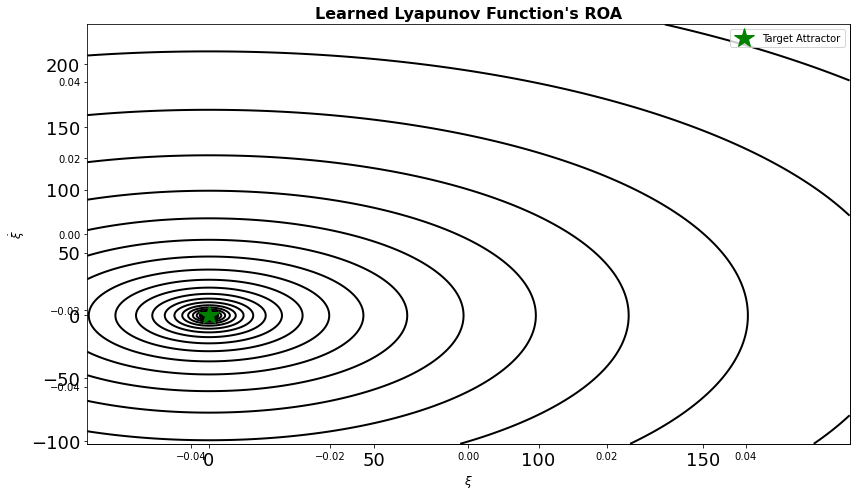

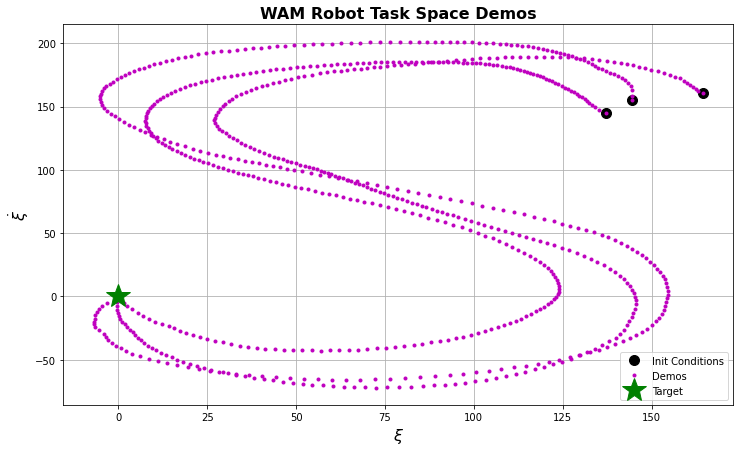

In [4]:
fontdict = {'fontsize':16, 'fontweight':'bold'}
# https://matplotlib.org/stable/users/interactive.html
plt.ion()

savedict = dict(save=True, savename='demos_w.jpg',\
        savepath=join("..", "scripts/docs"))
viz = Visualizer(winsize=(12, 7), savedict=savedict, data=data,
                labels=['Trajs', 'Dt(Trajs)']*2, alphas = [.15]*4,
                fontdict=fontdict)

Xinit = data[:Vxf['d'], demoIdx[0, :-1]]
level_args = dict(disp=True, levels = [], save=True)
viz.savedict["savename"]=f"demos_{args.model}.jpg"
viz.init_demos(Xinit, save=True)
# Optimize and plot the level sets of the Lyapunov function
viz.savedict["savename"]=f"level_sets_{args.model}.jpg"
handles = viz.level_sets(Vxf, cost, **level_args)
viz.draw()

In [5]:
if args.off_priors:
    mu, sigma, priors = Mu_EM, Sigma_EM, Priors_EM
else:
    gmm = GMM(num_clusters=options['num_clusters'])
    gmm.update(data.T, K=options['num_clusters'], max_iterations=100)
    mu, sigma, priors = gmm.mu.T, gmm.sigma.T, gmm.logmass.T

"Now stabilize the learned dynamics"
traj = list(range(Vxf['d']))
traj_derivs = np.arange(Vxf['d'], 2 * Vxf['d'])
# print(f'demoIdx: {demoIdx}')
Xinit = data[:Vxf['d'], demoIdx[0, :-1]]
stab_args = {'time_varying': False, 'cost': cost}
gmr_handle = lambda x: regress_gauss_mix(priors, mu, sigma, x, traj, traj_derivs)
stab_handle = lambda x: stabilizer(x, gmr_handle, Vxf, args.rho0, args.kappa0, **stab_args) #, priors, mu, sigma

if args.traj_nums:
    ds_options['traj_nums'] = args.traj_nums
ds_options['pause_time'] = args.pause_time
traj_corr = CorrectTrajectories(Xinit, [], stab_handle, Bundle(ds_options))


In [6]:
x_hist = np.stack(traj_corr.x_hist)
xd_hist = np.stack(traj_corr.xd_hist)
t_hist = np.stack(traj_corr.t_hist)
xT = traj_corr.XT

NameError: name 'point' is not defined

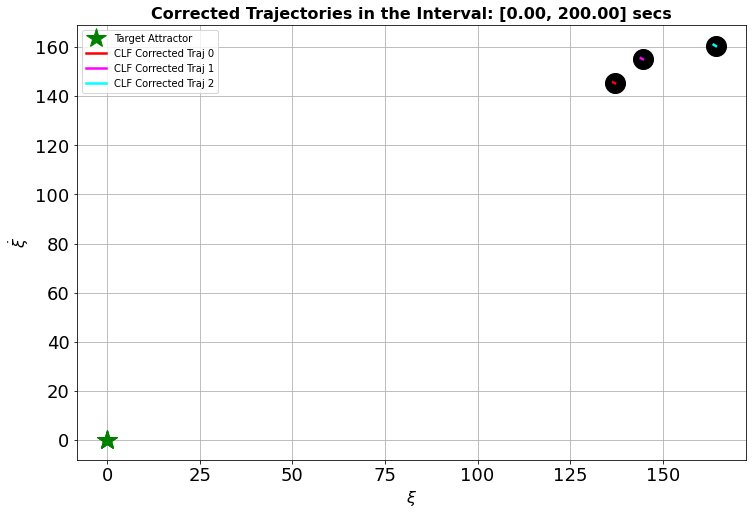

In [7]:
f = plt.figure(figsize=(12, 8))
plt.clf()
f.tight_layout()
args.fontdict = {'fontsize':16, 'fontweight':'bold'}


plt.ion()

_labelsize = 18
nbSPoint = x_hist.shape[-1]
cm = plt.get_cmap('ocean')
ax = f.gca()
ax.grid('on')
colors =['r', 'magenta', 'cyan']

# plot the target attractors
ax.plot(xT[0], xT[1], 'g*',markersize=20,linewidth=1.5, label='Target Attractor')

for j in range(nbSPoint):
    color = cm(1.0 * j / nbSPoint)
    h1, = ax.plot(Xinit[0, j], Xinit[1, j], 'ko', markersize=20,  linewidth=2.5)
    h1, = ax.plot(x_hist[:5, 0, j], x_hist[:5, 1, j], color=colors[j], markersize=2,  linewidth=2.5, label=f'CLF Corrected Traj {j}')
    
ax.set_xlabel('$\\xi$', fontdict=args.fontdict)
ax.set_ylabel('$\\dot{\\xi}$', fontdict=args.fontdict)

ax.xaxis.set_tick_params(labelsize=_labelsize)
ax.yaxis.set_tick_params(labelsize=_labelsize)

ax.legend(loc='upper left') #, bbox_to_anchor=(-1, .5))
ax.set_title(f'Corrected Trajectories in the Interval: [{t_hist[0]:.2f}, {t_hist[-1]:.2f}] secs', fontdict=args.fontdict)
point += 1


points = []
while point <=x_hist.shape[0]:
    for j in range(nbSPoint):
        color = cm(1.0 * j / nbSPoint)
        h1.set_data(Xinit[0, j], Xinit[1, j])
        h1.set_data(x_hist[:point, 0, j], x_hist[:point, 1, j])
        
        x_range = (Xinit[0, j], Xinit[1, j])
        ax.set_xlim(x_range)
        
        
        # drawing updated values
        figure.canvas.draw()

        # This will run the GUI event
        # loop until all UI events
        # currently waiting have been processed
        figure.canvas.flush_events()
        
        #plt.pause(.1)
        time.sleep(.1)
       

# plt.savefig(join("../scripts", "docs", f'corrected_traj_{args.model}.jpg'))
# plt.show()

In [ ]:
gs = gridspec.GridSpec(1, 1)
gs#[0]

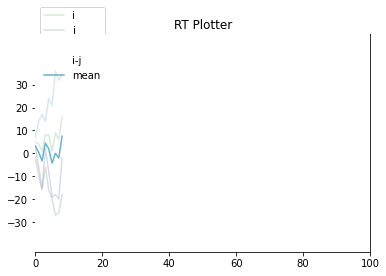

In [16]:

from visualization.realtime_plotter import RealtimePlotter
import matplotlib.gridspec as gridspec
import time
import random
import threading

def run_demo(demo_func):
    demo_thread = threading.Thread(target=demo_func)
    demo_thread.daemon = True
    demo_thread.start()

# Initialize Figure
fig = plt.figure()
gs = gridspec.GridSpec(2, 3)

def demo_realtime_plotter():
    i, j = 0, 0
    while True:
        i += random.randint(-10, 10)
        j += random.randint(-10, 10)
        data = [i, j, i + j, i - j]
        mean = np.mean(data)
#         print(mean)
        realtime_plotter.update(data + [mean])
        time.sleep(5e-3)

realtime_plotter = RealtimePlotter(fig, gs[3],
        labels=['i', 'j', 'i+j', 'i-j', 'mean'],
        alphas=[0.15, 0.15, 0.15, 0.15, 1.0], 
                                  time_window=100)
run_demo(demo_realtime_plotter)
# demo_realtime_plotter()

In [21]:
xi = np.empty((0, 1))
xi = np.append(xi, np.random.randn(5, 1, 1))
xi

array([ 0.71567546,  1.0144838 , -0.34841094,  1.16709297, -1.24934717])